# Motif Analysis

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import decoupler as dc
import bento as bt
import spatialdata as sd
import dask.dataframe as dd

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
sdata = sd.read_zarr("/mnt/d/ebola/data/24hpt.zarr")
sdata

SpatialData object, with associated Zarr store: /mnt/d/ebola/data/24hpt.zarr
├── Images
│     ├── '202406121440_HEK293T-VS219-24HPT-CompA-S1_VMSC12502_region_0_z0': DataTree[cyx] (10, 68947, 81046), (10, 34473, 40523), (10, 17236, 20261), (10, 8618, 10130), (10, 4309, 5065)
│     ├── 'condensate_multiotsu': DataArray[cyx] (1, 68947, 81046)
│     ├── 'dapi_processed': DataArray[cyx] (1, 68947, 81046)
│     └── 'polyt_processed': DataArray[cyx] (1, 68947, 81046)
├── Points
│     └── '202406121440_HEK293T-VS219-24HPT-CompA-S1_VMSC12502_region_0_transcripts': DataFrame with shape: (<Delayed>, 9) (2D points)
├── Shapes
│     ├── '202406121440_HEK293T-VS219-24HPT-CompA-S1_VMSC12502_region_0_polygons': GeoDataFrame shape: (118813, 9) (2D shapes)
│     ├── 'cellpose_boundaries': GeoDataFrame shape: (95878, 1) (2D shapes)
│     ├── 'cellpose_nucleus_boundaries': GeoDataFrame shape: (103286, 1) (2D shapes)
│     ├── 'condensate_shapes': GeoDataFrame shape: (130864, 1) (2D shapes)
│     ├── 'cyto

In [3]:
points_key = "202406121440_HEK293T-VS219-24HPT-CompA-S1_VMSC12502_region_0_transcripts"
points = sdata[points_key]
pt_transform = sd.transformations.get_transformation(
    points
)  # Get transformation saved in object
points = (
    sd.transform(points, pt_transform).reset_index(drop=True).compute()
)  # Apply transformation

# Format data for sdata
points = sd.models.PointsModel.parse(
    dd.from_pandas(points, npartitions=1),
    coordinates={"x": "x", "y": "y"},
)
# points.attrs = attrs
sdata.points["transcripts"] = points

In [4]:
bt.io.prep(
    sdata,
    points_key="transcripts",
    feature_key="gene",
    instance_key="cellpose_boundaries",
    shape_keys=[
        "cellpose_boundaries",
        "cellpose_nucleus_boundaries",
        "small_condensates",
        "cyto_no_cond",
    ],
)

  0%|          | 0/3 [00:00<?, ?it/s]

SpatialData object, with associated Zarr store: /mnt/d/ebola/data/24hpt.zarr
├── Images
│     ├── '202406121440_HEK293T-VS219-24HPT-CompA-S1_VMSC12502_region_0_z0': DataTree[cyx] (10, 68947, 81046), (10, 34473, 40523), (10, 17236, 20261), (10, 8618, 10130), (10, 4309, 5065)
│     ├── 'condensate_multiotsu': DataArray[cyx] (1, 68947, 81046)
│     ├── 'dapi_processed': DataArray[cyx] (1, 68947, 81046)
│     └── 'polyt_processed': DataArray[cyx] (1, 68947, 81046)
├── Points
│     ├── '202406121440_HEK293T-VS219-24HPT-CompA-S1_VMSC12502_region_0_transcripts': DataFrame with shape: (<Delayed>, 9) (2D points)
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 13) (2D points)
├── Shapes
│     ├── '202406121440_HEK293T-VS219-24HPT-CompA-S1_VMSC12502_region_0_polygons': GeoDataFrame shape: (118813, 9) (2D shapes)
│     ├── 'cellpose_boundaries': GeoDataFrame shape: (95878, 5) (2D shapes)
│     ├── 'cellpose_nucleus_boundaries': GeoDataFrame shape: (103286, 2) (2D shapes)
│     ├── 'cond

In [5]:
bt.tl.analyze_shapes(
    sdata,
    shape_keys=[
        "small_condensates",
        "cyto_no_cond",
        "cellpose_nucleus_boundaries",
        "cellpose_boundaries",
    ],
    feature_names=["density"],
    recompute=True,
)

  0%|          | 0/4 [00:00<?, ?it/s]

## Calculate Density Ratio

In [6]:
sdata["small_condensates_table"] = sdata.aggregate(
    values="transcripts",
    by="small_condensates",
    value_key="gene",
    agg_func="count",
    instance_key="cellpose_boundaries",
)["table"]

sdata["cyto_no_cond_table"] = sdata.aggregate(
    values="transcripts",
    by="cyto_no_cond",
    value_key="gene",
    agg_func="count",
    instance_key="cellpose_boundaries",
)["table"]

sdata["nucleus_table"] = sdata.aggregate(
    values="transcripts",
    by="cellpose_nucleus_boundaries",
    value_key="gene",
    agg_func="count",
    instance_key="cellpose_boundaries",
)["table"]


In [7]:
condensate_density = (
    sdata["small_condensates"]
    .set_index("cellpose_boundaries")["small_condensates_density"]
    .dropna()
)

# Drop cells whose index name is nan
condensate_density = condensate_density[condensate_density.index.notna()]

cytoplasm_density = (
    sdata["cyto_no_cond"]
    .set_index("cellpose_boundaries")["cyto_no_cond_density"]
    .dropna()
)

nucleus_density = (
    sdata["cellpose_nucleus_boundaries"]
    .set_index("cellpose_boundaries")["cellpose_nucleus_boundaries_density"]
    .dropna()
)

nucleus_density = nucleus_density[nucleus_density.index.notna()]

cell_density = sdata["cellpose_boundaries"]["cellpose_boundaries_density"].dropna()

In [8]:
densities = pd.concat(
    [condensate_density, cytoplasm_density, nucleus_density, cell_density], axis=1
).dropna()

density_ratios = densities.divide(densities["cellpose_boundaries_density"], axis=0)

In [9]:
# Define the key for cell boundaries
cell_key = "cellpose_boundaries"

# Get cell areas
cell_area = sdata[cell_key][cell_key + "_area"]

# Get cell count data
cell_count = sdata["table"].to_df()

# Get condensate measurements
cond_cell_index = sdata["small_condensates"][
    cell_key
].dropna()  # Get condensate to cell index mapping
cond_area = (  # Get area of each condensate ordered by cell order
    sdata["small_condensates"]
    .set_index(cell_key)
    .loc[cond_cell_index, "small_condensates_area"]
    .reindex(cell_area.index)
    .fillna(0)
)
cond_count = (  # Get count of transcripts in each condensate ordered by cell order
    sdata["small_condensates_table"].to_df().reindex(cell_area.index).fillna(0)
)

# Get nucleus measurements
nucleus_index = sdata["cellpose_nucleus_boundaries"][
    cell_key
].dropna()  # Get condensate to cell index mapping
nucleus_area = (  # Get area of each condensate ordered by cell order
    sdata["cellpose_nucleus_boundaries"]
    .set_index(cell_key)
    .loc[nucleus_index, "cellpose_nucleus_boundaries_area"]
    .reindex(cell_area.index)
    .fillna(0)
)
nucleus_count = (  # Get count of transcripts in each condensate ordered by cell order
    sdata["nucleus_table"].to_df().reindex(cell_area.index).fillna(0)
)

# Process cytoplasm data
cyto_cell_index = sdata["cyto_no_cond"][cell_key]  # Get cytoplasm to cell index mapping
cyto_area = (  # Get area of each cytoplasm ordered by cell order
    sdata["cyto_no_cond"]
    .set_index(cell_key)
    .loc[cyto_cell_index, "cyto_no_cond_area"]
    .reindex(cell_area.index)
    .fillna(0)
)
cyto_count = (  # Get count of transcripts in each cytoplasm ordered by cell order
    sdata["cyto_no_cond_table"]
    .to_df()
    .set_index(cyto_cell_index)
    .reindex(cell_area.index)
    .fillna(0)
)

## Filter cells and genes

- filter out cells with no condensates
- filter out genes not expressed in at least .5% of cells
- filter out cells with low expression

In [10]:
has_nucleus = nucleus_area > 0
has_nucleus.value_counts() / len(has_nucleus)

# Has condensate filter
has_condensates = cond_area > 0
has_condensates.value_counts() / len(has_condensates)

small_condensates_area
False    0.673032
True     0.326968
Name: count, dtype: float64

In [11]:
# Filter cell properties with condensates
cell_area = cell_area[has_condensates & has_nucleus]
cell_count = cell_count[has_condensates & has_nucleus]

# filter condensate properties with condensates
cond_area = cond_area[has_condensates & has_nucleus]
cond_count = cond_count[has_condensates & has_nucleus]

# filter nucleus properties with condensates
nucleus_area = nucleus_area[has_condensates & has_nucleus]
nucleus_count = nucleus_count[has_condensates & has_nucleus]

# filter cytoplasm properties with condensates
cyto_area = cyto_area[has_condensates & has_nucleus]
cyto_count = cyto_count[has_condensates & has_nucleus]

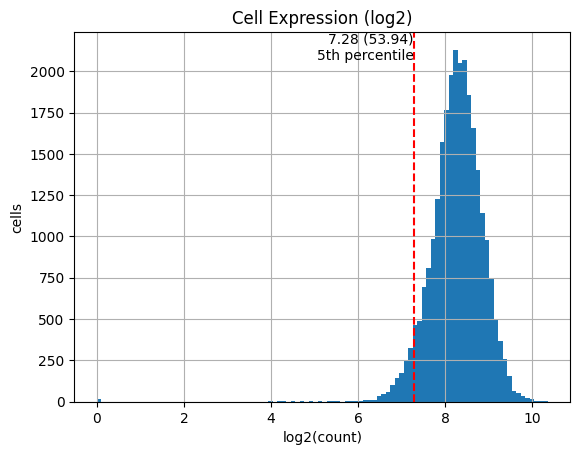

True     25417
False     1311
Name: count, dtype: int64

In [12]:
log_cell_expr = np.log2(cell_count.sum(axis=1) + 1)
min_expr = np.percentile(log_cell_expr, 5)
ax = log_cell_expr.hist(bins=100)
ax.axvline(min_expr, color="red", linestyle="--")
ax.text(
    min_expr,
    ax.get_ylim()[1],
    f"{min_expr:.2f} ({min_expr**2 + 1:.2f})\n5th percentile",
    ha="right",
    va="top",
)
plt.xlabel("log2(count)")
plt.ylabel("cells")
plt.title("Cell Expression (log2)")
plt.show()

valid_cells = log_cell_expr >= min_expr
valid_cells.value_counts()


In [13]:
# Filter cells
cell_area = cell_area[valid_cells]
cell_count = cell_count[valid_cells]

# filter condensates
cond_area = cond_area[valid_cells]
cond_count = cond_count[valid_cells]

# filter nucleus
nucleus_area = nucleus_area[valid_cells]
nucleus_count = nucleus_count[valid_cells]

# filter cytoplasms
cyto_area = cyto_area[valid_cells]
cyto_count = cyto_count[valid_cells]

In [14]:
with open("RNA_lengths.txt", "r") as f:
    rna_lengths = pd.read_csv(f, sep="\t", index_col="gene")

In [15]:
target_genes = [
    "AKT3",
    "BCL7A",
    "CCND3",
    "CD9",
    "CLIP1",
    "DCP1A",
    "E2F7",
    "EHD4",
    "PKR",
    "GPATCH11",
    "HSPH1",
    "IARS",
    "LAP3",
    "MAP3K5",
    "MEX3A",
    "MOV10",
    "NFE2L1",
    "ODC1",
    "OTUD3",
    "PFKFB3",
    "SAMHD1",
    "SCOTIN",
    "SLC25A28",
    "STAT1",
    "SWAP70",
    "TRIM25",
    "UBXN1",
    "WARS",
    "ZAP",
]

with open("target_genes.txt", "w") as file:
    for gene in target_genes:
        file.write(gene + "\n")

In [16]:
target_length = rna_lengths.loc[target_genes]["length"].mean()
nontarget_gene_lengths = rna_lengths[~rna_lengths.index.isin(target_genes)]
nontarget_gene_lengths["abs_diff"] = abs(
    nontarget_gene_lengths["length"] - target_length
)

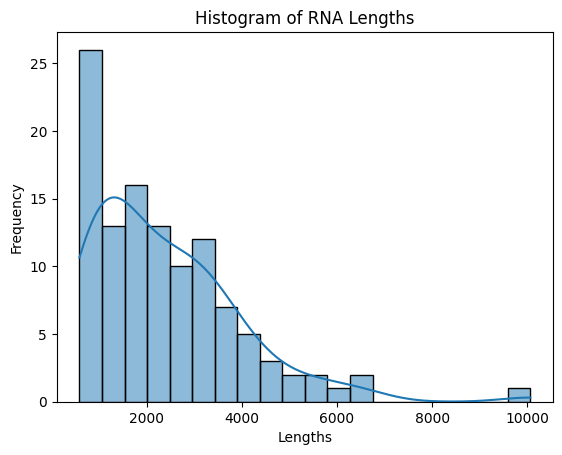

In [17]:
# Plot the histogram
sns.histplot(data=nontarget_gene_lengths, x="length", bins=20, kde=True)
plt.xlabel("Lengths")  # Optional: Label for x-axis
plt.ylabel("Frequency")  # Optional: Label for y-axis
plt.title("Histogram of RNA Lengths")  # Optional: Title
plt.show()

In [18]:
background_genes = nontarget_gene_lengths.sort_values("abs_diff").head(50).index

with open("background_genes.txt", "w") as file:
    for gene in background_genes:
        file.write(gene + "\n")

In [19]:
target_length

4361.862068965517

In [20]:
nontarget_gene_lengths.sort_values("abs_diff").head(50)

,length,abs_diff
gene,,
ZNF10,4406,44.137931
IFIT1,4302,59.862069
MORC3,4224,137.862069
DDX58,4628,266.137931
BTG1,4629,267.137931
NANOS1,4017,344.862069
HSPA5,3921,440.862069
SLC16A1,3910,451.862069
CTCFL,3864,497.862069
